### the goal of this notebook is to compare orthophotos of varying resolutions and compressions

In [21]:
import rasterio
from rasterio.windows import Window
import os
import matplotlib.pyplot as plt
import rasterio.plot
import numpy as np



C:\Users\nilsdi\AppData\Local\Temp\ipykernel_2588\1653258213.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


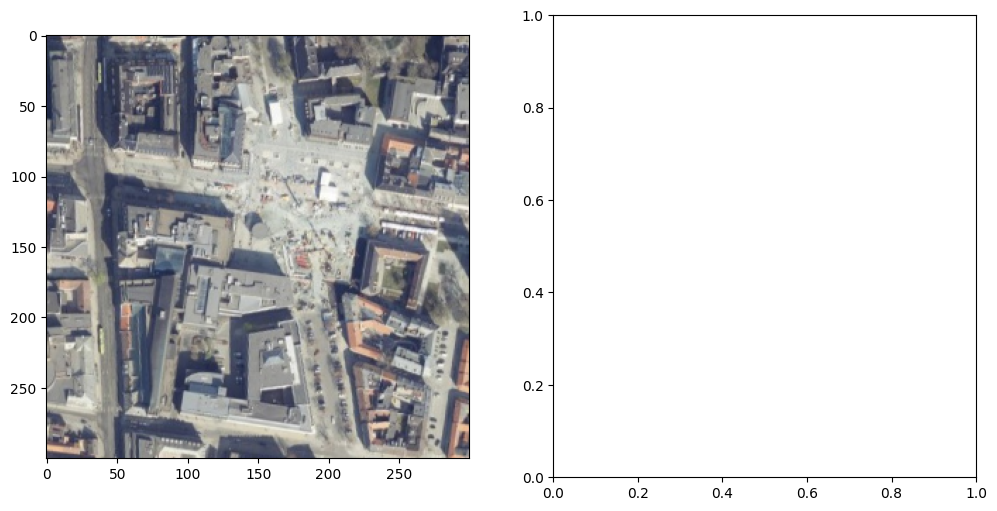

In [32]:
compared_settings = [
    {'res':1, 'project':'trondheim 2019', 'compression_value':50},
    #{'res':1, 'project':'trondheim 2019', 'compression_value':50},
    ]
project_paths = []
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
for data in compared_settings:
    file_name = f"i_lzw_{data['compression_value']}/Eksport-nib.tif"
    extract_path = parent_dir + f"/data/raw/orthophoto/res_{data['res']}/{data['project']}/"
    project_paths.append(extract_path + file_name)

# Define a shared window
col_off = 19500  # column offset (in m)
row_off = 3900  # row offset (in m)
width = 300  # width of the window (in m)
height = 300  # height of the window (in m)


# set up a multifigure plot to compare the orthophotos
# make sure we have enough rows for all projects (2 columns and as many rows as needed)
n_rows = round(len(project_paths)/2 + 0.25)
fig, axs = plt.subplots(n_rows, 2, figsize=(12, 6))

# Flatten the axs array to easily iterate over it
axs = axs.flatten()

for ax, geotiff_path, settings in zip(axs, project_paths, compared_settings):
    # Create a window that is adjusted for pixels (not meters)
    pixel_size = settings['res']
    window = Window(col_off/pixel_size, row_off/pixel_size, width/pixel_size, height/pixel_size)
    # Read the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        # Read a subset of the GeoTIFF data
        subset = src.read([1,2,3], window=window)
        # Display the data in the current subplot
        #rasterio.plot.show(subset, ax=ax, transform=src.transform)
        # Rearrange the dimensions of the array
        subset = np.transpose(subset, (1, 2, 0))
        # Display the data in the current subplot
        ax.imshow(subset)
fig.show()


In [34]:
project_paths[0]

'c:\\Users\\nilsdi\\OneDrive - NTNU\\Personal_Python\\demolition_footprints/data/raw/orthophoto/res_1/trondheim 2019/i_lzw_50/Eksport-nib.tif'

In [37]:
## make a function that cuts out a window from a geotiff

def get_image_from_geotiff(geotiff_path, bbox:list, resolution)->np.array:
    """
    Function that reads a geotiff and returns a subset of the image

    Arguments:
    geotiff_path : str : path to the geotiff file
    bbox : list : [left, bottom, right, top] coordinates of the bounding box
    resolution : int : resolution specified by size of edges of pixels in m

    Returns:
    np.array : subset of the image
    """
    target_crs = 'EPSG:4326'  # WGS84
    # Define the bounding box and the resolution
    [left, bottom, right, top] = bbox

    # Read the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        # convert crs of the tiff to target crs
        if src.crs != target_crs:
            src = src.to_crs(target_crs)
        # Convert the bounding box to pixel coordinates
        left_col, top_row = src.index(left, top)
        right_col, bottom_row = src.index(right, bottom)

        # Make a window from the bounding box
        window = Window.from_slices((top_row, bottom_row), (left_col, right_col))

        # Read a subset of the GeoTIFF data
        subset = src.read([1,2,3], window=window)
        # Rearrange the dimensions of the array
        subset = np.transpose(subset, (1, 2, 0))
    return subset
bbox = [10.4081, 63.4305, 10.4101, 63.4325]
subset = get_image_from_geotiff(project_paths[0], bbox, 1)

# display the subset
plt.imshow(subset)

AttributeError: 'DatasetReader' object has no attribute 'to_crs'

the size of the image is 36995x37907 pixels
3853 20329 4068 20445
 the window is Window(col_off=20329, row_off=3853, width=116, height=215)


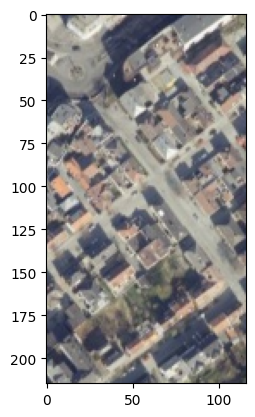

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 the new_transform is | 0.00, 0.00, 10.41|
| 0.00,-0.00, 63.43|
| 0.00, 0.00, 1.00|
 the subset_transform is | 1.00, 0.00, 270986.91|
| 0.00,-1.00, 7041985.62|
| 0.00, 0.00, 1.00|
 the src transform is | 1.00, 0.00, 250657.91|
| 0.00,-1.00, 7045838.62|
| 0.00, 0.00, 1.00|
 the subset_transform is | 1.00, 0.00, 270986.91|
| 0.00,-1.00, 7041985.62|
| 0.00, 0.00, 1.00|


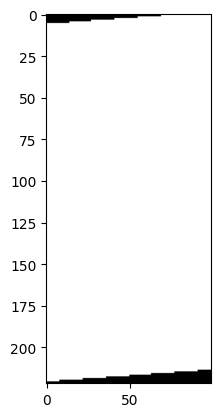

In [82]:
from rasterio import warp
from affine import Affine

def get_image_from_geotiff(geotiff_path, bbox:list, resolution)->np.array:
    """
    Function that reads a geotiff and returns a subset of the image

    Arguments:
    geotiff_path : str : path to the geotiff file
    bbox : list : [left, bottom, right, top] coordinates of the bounding box
    resolution : int : resolution specified by size of edges of pixels in m

    Returns:
    np.array : subset of the image
    """
    target_crs = 'EPSG:4326'  # WGS84
    # Define the bounding box and the resolution
    [left, bottom, right, top] = bbox

    # Read the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        print(f'the size of the image is {src.width}x{src.height} pixels')
        # if the crs of the tiff is not the target crs, reproject the bbox
        # if the crs of the tiff is not the target crs, reproject the bbox
        # if the crs of the tiff is not the target crs, reproject the bbox
        if src.crs != target_crs:
            left, bottom = warp.transform(target_crs, src.crs, [left], [bottom])
            right, top = warp.transform(target_crs, src.crs, [right], [top])
            left, bottom = left[0], bottom[0]
            right, top = right[0], top[0]

        # Convert the bounding box to pixel coordinates
        left_col, top_row = src.index(left, top)
        right_col, bottom_row = src.index(right, bottom)
        print(left_col, top_row, right_col, bottom_row)

        # Make a window from the bounding box
        window = Window(top_row, left_col, bottom_row - top_row, right_col - left_col)
        print(f' the window is {window}')

        # Read a subset of the GeoTIFF data
        subset = src.read([1,2,3], window=window)
        # just for testing display the subset
        plt.figure()
        plt.imshow(np.transpose(subset, (1, 2, 0)))
        plt.show()

        # before overwriting the top, left etc in the src crs, lets make the transform of the subset.
        # Calculate the transform for the subset for the later reprojecting


        # Make a window from the bounding box
        #window = Window(left_col, top_row, right_col - left_col, bottom_row - top_row)

        # Calculate the transform for the window
        subset_transform = src.window_transform(window)

        # if the crs of the tiff is not the target crs, reproject the subset
        if src.crs != target_crs:
            # Define the bounding box and the resolution for the target crs
            left, bottom, right, top = bbox
            # Calculate the scaling factors
            scaling_factor_y = 1 / (pixel_size / 111320)  # scaling factor in the y direction
            scaling_factor_x = scaling_factor_y * np.cos(np.radians((bottom + top) / 2))  # scaling factor in the x direction

            # Calculate the dimensions and the transform of the new GeoTIFF
            width = int((right - left) * scaling_factor_x)
            height = int((top - bottom) * scaling_factor_y)

            # Create an empty array for the reprojected data
            reprojected_subset = np.empty((subset.shape[0], height, width))

            # Calculate the new transform
            new_transform = rasterio.transform.from_bounds(left, bottom, right, top, width, height)
            print(f' the new_transform is {new_transform}')
            print(f' the subset_transform is {subset_transform}')
            print(f' the src transform is {src.transform}')
            # Calculate the transform for the subset
            # Calculate the transform for the window
            #subset_transform = src.window_transform(window)
            print(f' the subset_transform is {subset_transform}')
            # Reproject the subset
            warp.reproject(
                source=subset,
                destination=reprojected_subset,
                src_transform=subset_transform,
                src_crs=src.crs,
                dst_transform=new_transform,
                dst_crs=target_crs,
                resampling=warp.Resampling.nearest)

            subset = reprojected_subset

        # Rearrange the dimensions of the array
        subset = np.transpose(subset, (1, 2, 0))
    return subset

bbox = [10.4081, 63.4305, 10.4101, 63.4325]
subset = get_image_from_geotiff(project_paths[0], bbox, 1)

# display the subset
# Display the subset
plt.imshow(subset, vmin=subset.min(), vmax=80)

In [79]:
print(f'dtype is {subset.dtype}.')
print(f'minmum value is {subset.min()} and maximum value is {subset.max()}, the median is {subset}.')

dtype is float64.
minmum value is 0.0 and maximum value is 255.0.


In [80]:
subset

array([[[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [145., 143., 125.],
        [134., 132., 112.],
        [132., 130., 111.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [146., 143., 124.],
        [143., 141., 120.],
        [133., 132., 113.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [139., 137., 117.],
        [140., 139., 118.],
        [134., 134., 115.]],

       ...,

       [[ 57.,  59.,  73.],
        [ 87.,  88.,  96.],
        [159., 159., 163.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[ 49.,  51.,  64.],
        [ 58.,  60.,  64.],
        [ 95.,  95.,  94.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,  